# CS 109A/AC 209A/STAT 121A Data Science: Homework 7
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 9th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW7.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [252]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
import StringIO
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Tarazi, Ramez]

### Part (b): Course Number

[CS 109a]

### Part (c): Who did you work with?

None

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Monitoring Land Cover Changes Using Satellite Images
In the face of rapid urban development and climate change, it is now more urgent than ever for governments (and other organizations) to have a detailed, accurate and up-to-date picture of land use and land cover, as well as how the land use/cover is changing over time, in order to make effective policy decision to manage and protect natural resources. Building such a comprehensive picture of land use/cover for a large region is extremely difficult. 

Recent improvements in satellite imagery and image process have allowed for new tools in land use/cover analysis. The following is an image of the change in vegetation cover around Belize from 1975 to 2007:

<img src="sat.jpg">

In this problem, we will explore how to use classifiers to detect the presence and location of vegetation in satellite images.


### Part 1(a): Detecting vegetation in satellite images

The following files contain sampled locations from satelite aeriel images: `dataset_1.txt`, ... `dataset_4.txt`. The first two columns contain the normalized latitude and longitude values. The last column indicates whether or not the location contains vegetation, with 1 indicating the presence of vegetaion and 0 indicating otherwise. 

These small sets of labels are typically generated by hand (that is, locations might be classified based on field studies or by cross-referencing with government databases). Your task is to use the labeled locations to train a model that will predict whether a new location is vegetation or non-vegetation.

- Suppose we were asked to write a computer program to automatically identify the vegetation regions on the landscape. How can we use the model fitting algorithms you have studied so far to identify the boundaries of the vegetation regions? In particular, discuss the suitability of the following algorithms for each of the four data sets (**you do not need to evaluate your classifier, build your argument using data and decision boundary visualizations**): 
    - linear or polynomial linear regression
    - linear or polynomial logistic regression
    - linear or quadratic discriminant analysis
    - decision trees

- By a quick visual inspection of each data set, what do you think is the smallest depth decision tree that would provide a good fit of the vegetation boundaries in each case? Does `sklearn`'s decision tree fitting algorithm always provide a good fit for the proposed depth? If not, explain why. **Support your answer with suitable visualization**.

We provide you with a function `plot_tree_boundary` to visualize a decision tree model on the data set.

In [2]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (array of predictors)
#      y (array of labels)
#      model (the decision tree you want to visualize, already fitted)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [3]:
#Load the data from satellite image #1 
sat_img_1 = pd.read_csv('datasets/dataset_1.txt', delimiter=',', header=None)
#Check out the data - sanity check
sat_img_1.head()

,0,1,2
0,0.566809,0.788130,1.0
1,0.400046,0.620933,1.0
2,0.458702,0.536935,1.0
3,0.474504,0.638224,1.0
4,0.558707,0.715527,1.0


In [4]:
#The data looks ok, so let's load the rest of the images
sat_img_2 = pd.read_csv('datasets/dataset_2.txt', delimiter=',', header=None)
sat_img_3 = pd.read_csv('datasets/dataset_3.txt', delimiter=',', header=None)
sat_img_4 = pd.read_csv('datasets/dataset_4.txt', delimiter=',', header=None)

#Make a list of the four dataframes so we can iterate through them later
sat_images = [sat_img_1, sat_img_2, sat_img_3, sat_img_4]

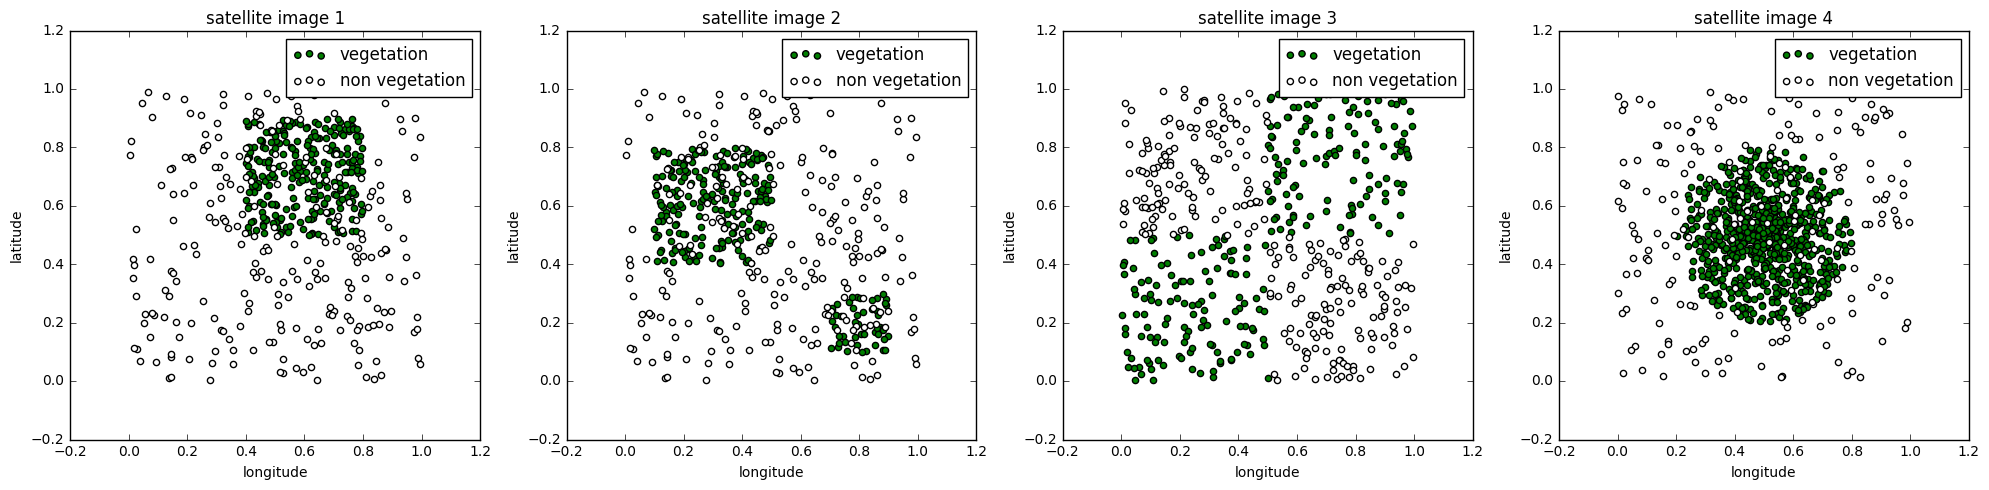

In [5]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]
    
    #Plot vegetation locations as green dots
    ax[i].scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation')
    #Plot non-vegetation locations as white dots
    ax[i].scatter(x[y == 0, 0], x[y == 0, 1], c='white', label='non vegetation')
    
    #Label everything
    ax[i].set_xlabel('longitude')
    ax[i].set_ylabel('latitude')
    ax[i].set_title('satellite image {}'.format(i + 1))
    ax[i].legend()
    
plt.tight_layout()
plt.show() 

For each image, based on the sample of we want to train a classifier that will classify a location as vegetation or non-vegetation.

Since the vegetation seem to be clustered in isolated regions in each image. Classifying locations with vegetation involves learning a boundary around each region. We then classify the points inside this region as vegetation and points outside as non-vegetation.

Formally speaking, the vegetation regions in an image can be identified by treating the latitude and longitude values as predictors and the vegetation information as a binary response, and fitting a classification model. The decision boundaries of these classifiers then allow us to identify the vegetation regions.

### Step 2: Classify locations with vegetation

How can we use the models we have studied so far to identify the boundaries of the vegetation regions? 

Let's consider:

    1. linear or polynomial logistic regression
    2. linear or quadratic discriminant analysis
    3. decision trees

Looking at the data, can you intuitively tell which model will perform best on which data set? 

What do you think is the smallest depth decision tree that would provide a good fit of the vegetation boundaries in each case?

(***Experimentation Suggested***)

In [6]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (classifier)
#      poly_flag (fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='white')
    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

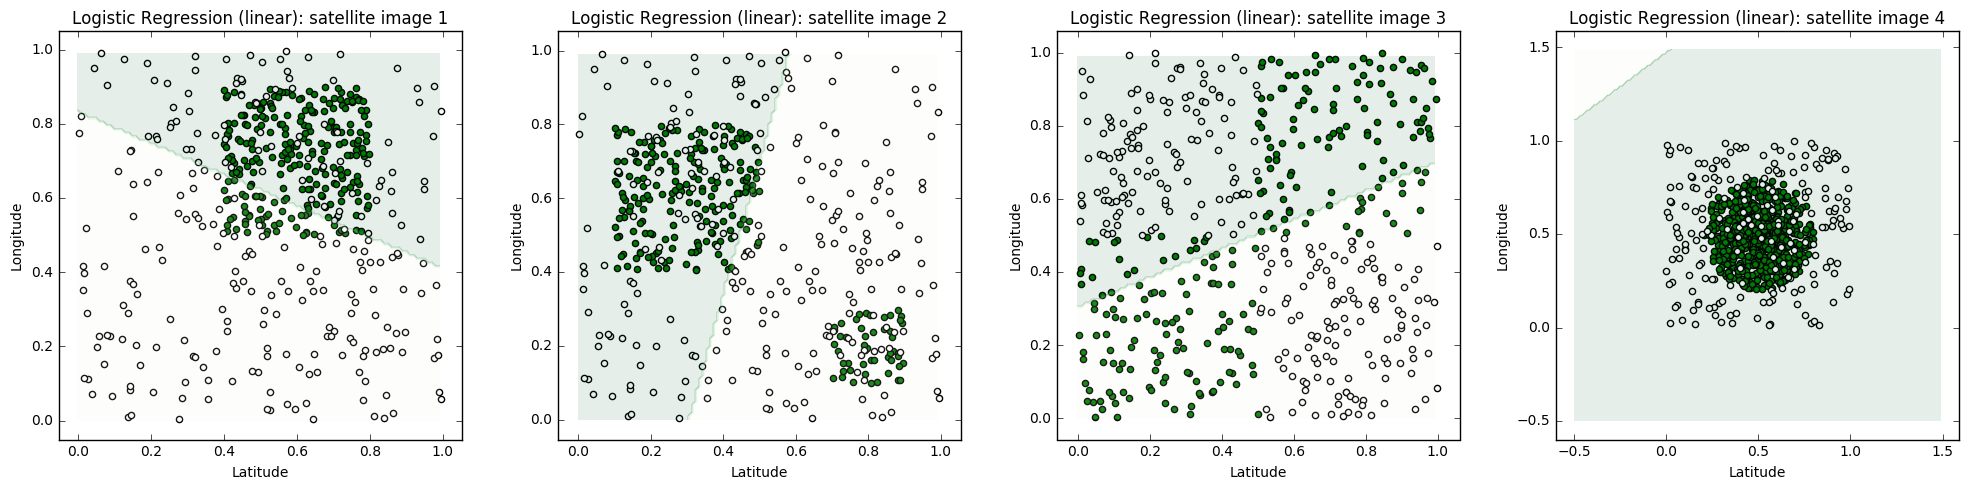

In [7]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Create a logistic regression model with linear boundary
logreg = linear_model.LogisticRegression()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]    
    
    #Fit our logistic regression model
    logreg.fit(x, y)
    
    #Change the bounds on the scatter plot (the 4th dataframe needs a larger frame)
    if i == 3:
        bounds = (-0.5, 1.5)
    else:
        bounds = (0, 1)
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, logreg, 
                                   'Logistic Regression (linear): satellite image {}'.format(i + 1), 
                                   ax[i], bounds)
    

plt.tight_layout()
plt.show()

[[-15.77894455  45.60378485  57.83803683 -49.26360545  20.21789142
  -49.05437198]]
[[ -6.73240213  24.55549166  39.27037449 -12.05924263 -32.74808594
  -25.06270608]]
[[  17.81201139  -69.52198315  -73.2017709    -2.00863253  143.17234324
     2.29064181]]
[[ -8.08706466  44.31032286  39.35848862 -45.08081672   1.57093006
  -41.48122868]]


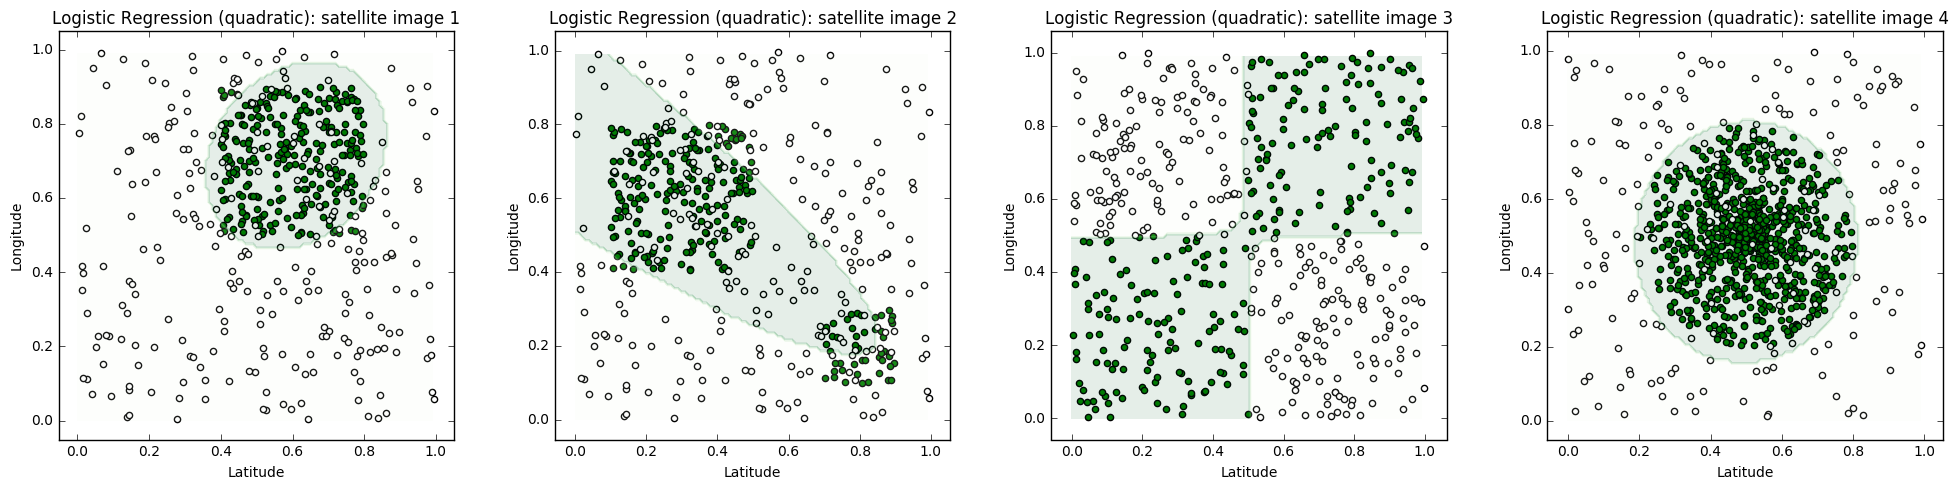

In [8]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
logreg_poly = linear_model.LogisticRegression(C=1000)

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Expand our predictor array with quadratic terms
    quad_features = preprocessing.PolynomialFeatures(degree = 2)
    x_expanded = quad_features.fit_transform(x)
    
    #Fit logistic regression model with quadratic decision boundary
    logreg_poly.fit(x_expanded, y)
    print logreg_poly.coef_
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, logreg_poly, 'Logistic Regression (quadratic): satellite image {}'.format(i + 1), ax[i], poly_flag=True)
    

plt.tight_layout()
plt.show()

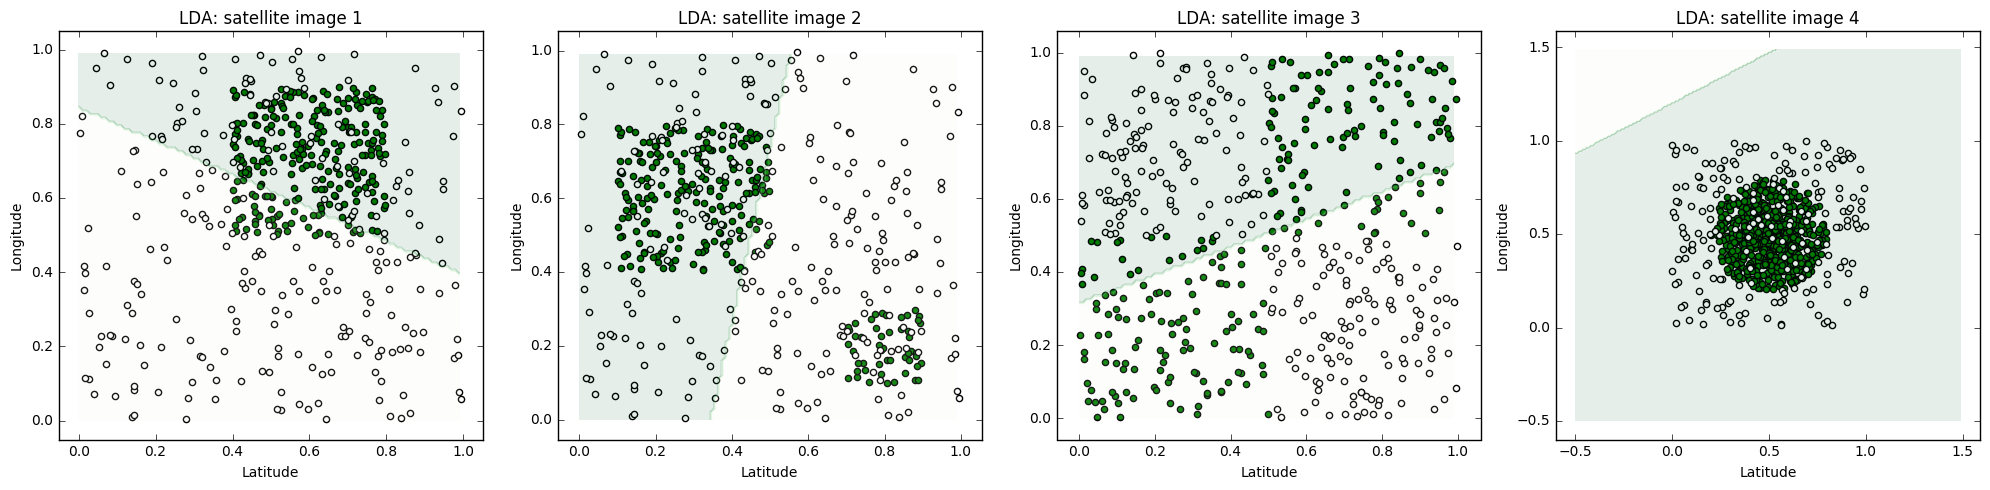

In [9]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# LDA
lda = discriminant_analysis.LinearDiscriminantAnalysis()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Fit our LDA model
    lda.fit(x, y)
    
    #Change the bounds on the scatter plot (the 4th dataframe needs a larger frame)
    if i == 3:
        bounds = (-0.5, 1.5)
    else:
        bounds = (0, 1)
        
    #Plot the data along with the decision boundary learned by our model    
    ax[i] = plot_decision_boundary(x, y, lda, 'LDA: satellite image {}'.format(i + 1), ax[i], bounds)
    

plt.tight_layout()
plt.show()

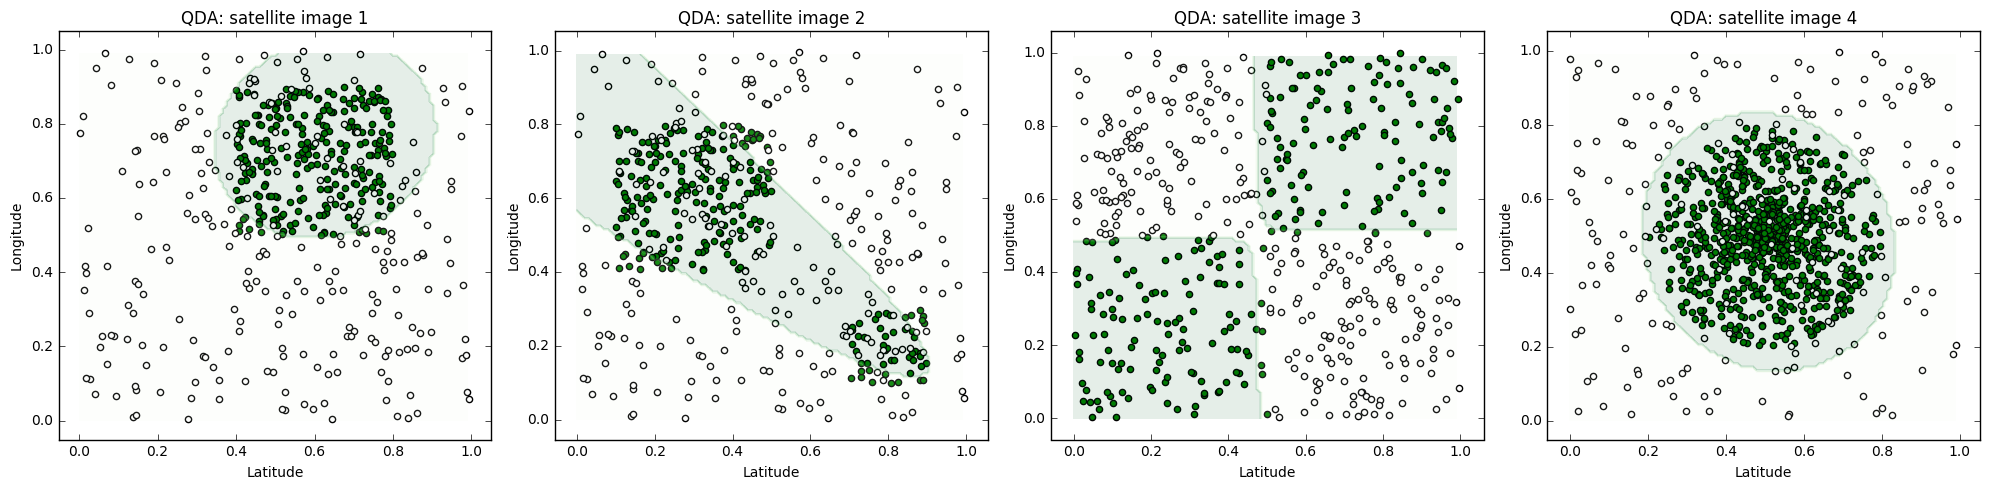

In [10]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Fit our QDA model
    qda.fit(x, y)
        
    #Plot the data along with the decision boundary learned by our model 
    ax[i] = plot_decision_boundary(x, y, qda, 'QDA: satellite image {}'.format(i + 1), ax[i])
    

plt.tight_layout()
plt.show()


- **Linear logistic regression / LDA:** Given that the vegetation regions are rectangular or elliptical in shape, a linear classification is not well-suited.

- **Quadratic logistic regression / QDA:** These methods will be able to accurately detect the vegetation regions in `dataset_4`, but will not be good fits the other data sets.

- **Decision trees:** This method will provide good fits for the first three data sets, where the region boundaries are rectangular. A decision tree is not best suited `dataset_4`, as to get a good fit, the tree depth needs to be very large. 

We've built you a helper function `plot_decision_boundary` to visualize a decision tree model on the data set.

In [11]:
#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax)
    
    return ax

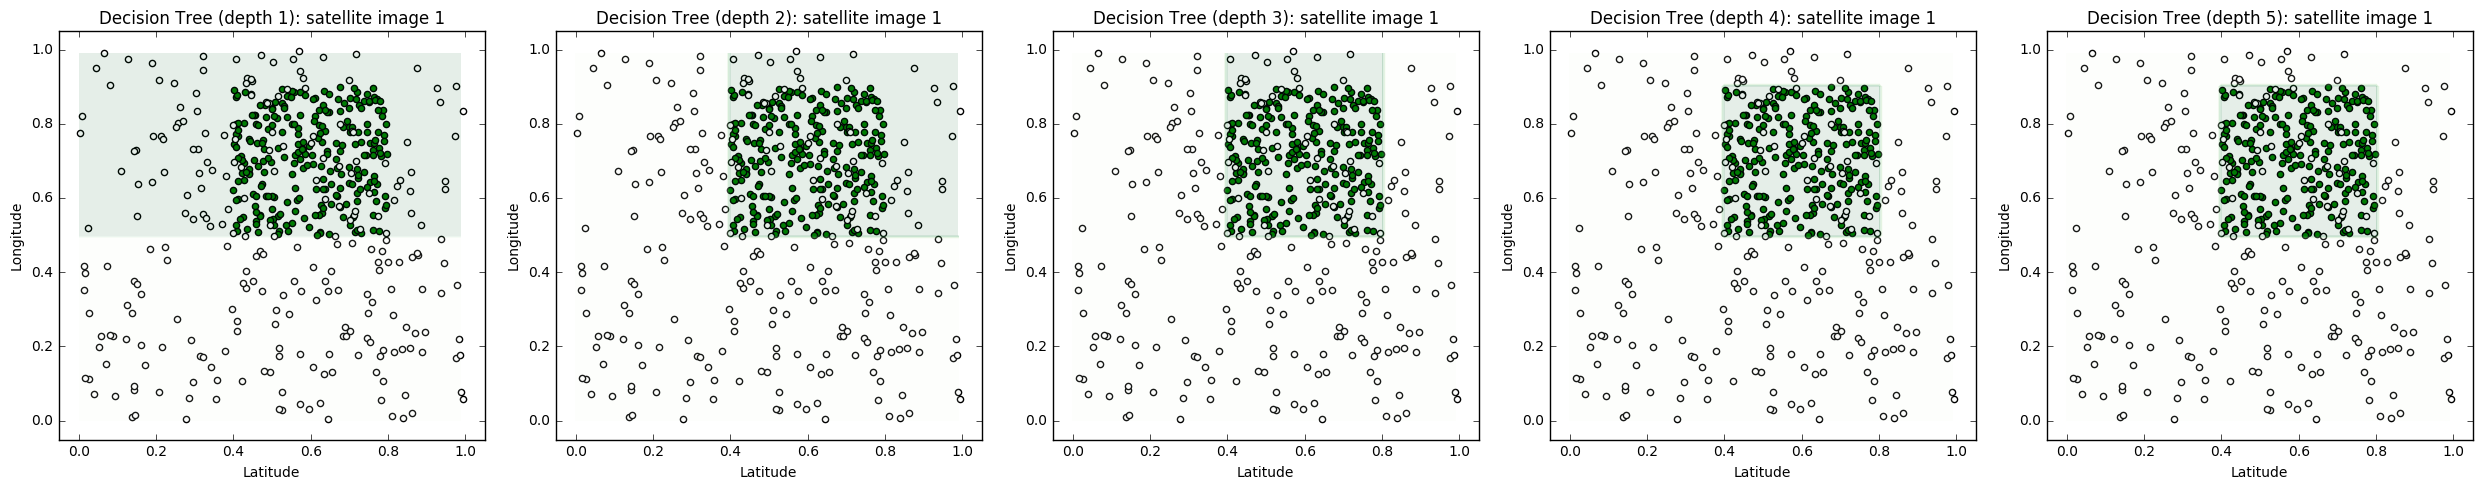

In [12]:
# Plot for dataset_1.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = sat_images[0].values[:, :-1]
#Get the class labels
y = sat_images[0].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 1'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

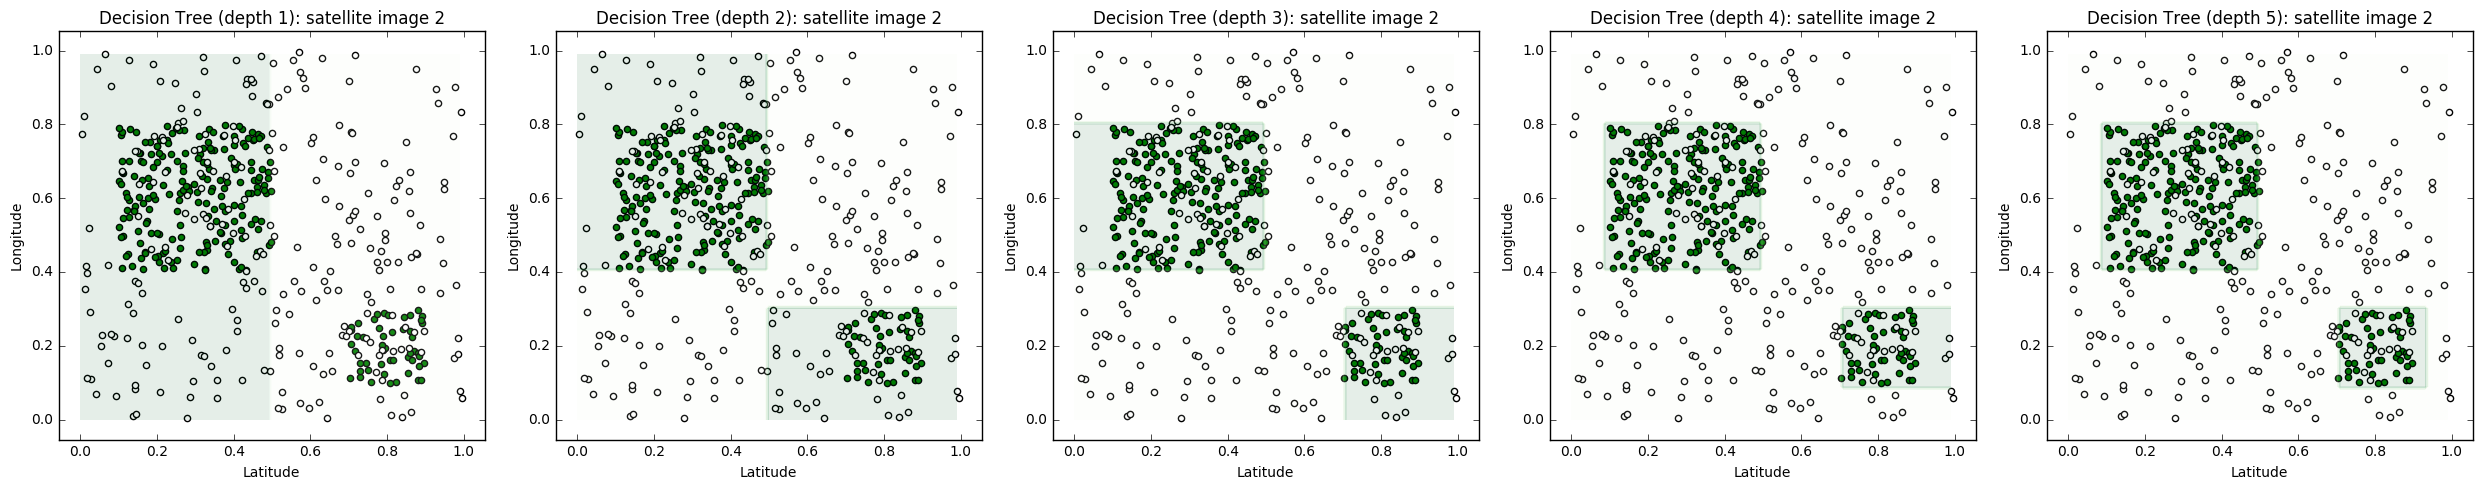

In [13]:
# Plot for dataset_2.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))

#Get the long/lat coords
x = sat_images[1].values[:, :-1]
#Get the class labels
y = sat_images[1].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 2'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

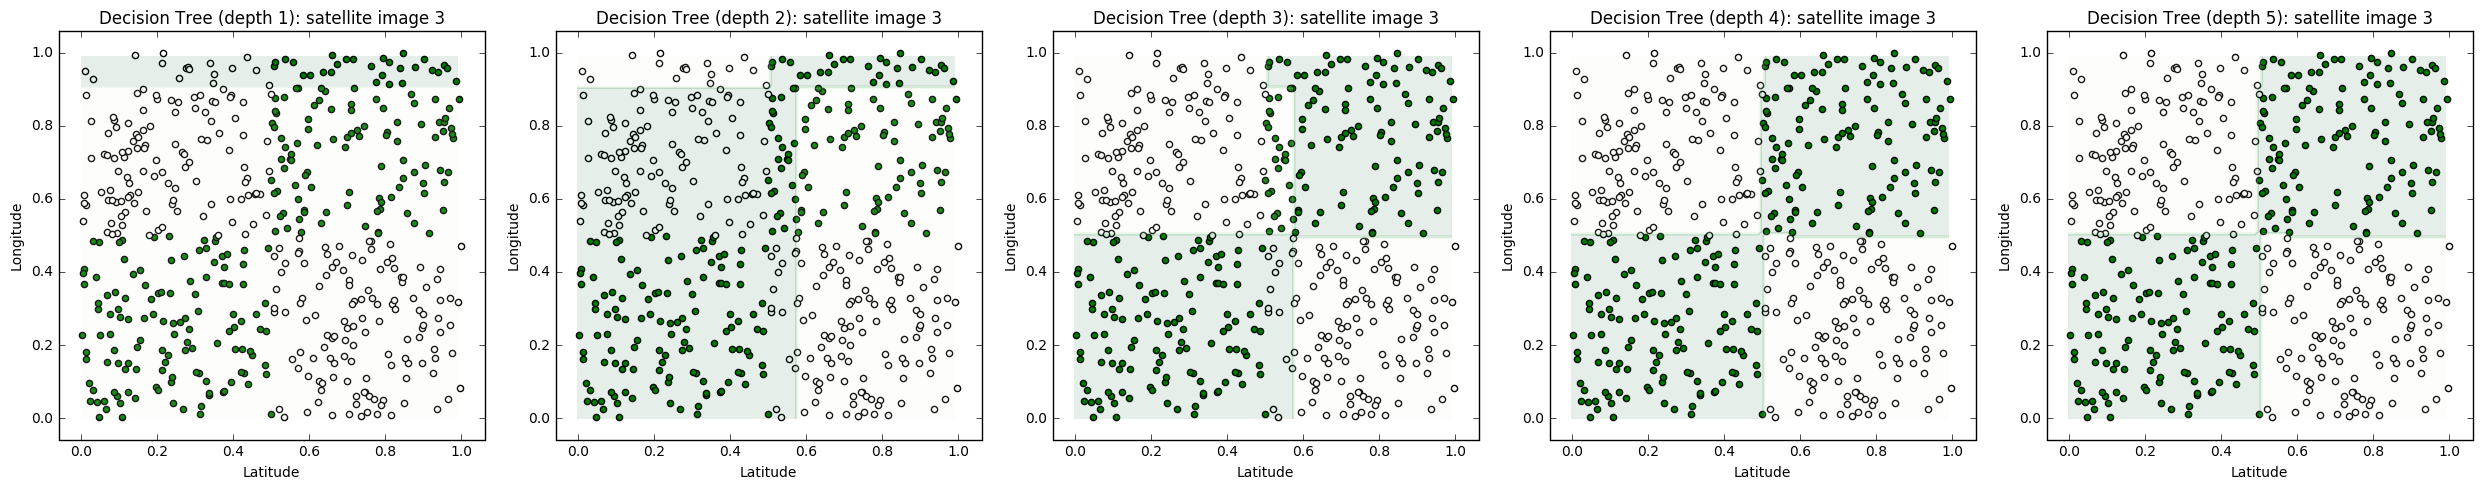

In [14]:
# Plot for dataset_3.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))

#Get the long/lat coords
x = sat_images[2].values[:, :-1]
#Get the class labels
y = sat_images[2].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 3'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

Since the vegetation region in dataset 1 takes the shape of a rectangle, a decision tree with a minimum depth of 4 is needed to define this region: one to check each of left x-limit, right x-limit, lower y-limit and upper y-limit. 

The vegetation in dataset 2 spans two rectangles of different sizes, a naive guess would be that we need a decision tree of depth 8, one for each corner of the two rectangles. However it suffices to use a simpler **5-level** tree: each rectangle can be captured by a decision tree of depth 4, and the root node branches to one of these trees.

Since the vegetation region in dataset 1 takes the shape of two rectangles lined up along their diagonals.  A depth 2 decision tree would have sufficed for this data set. However, due to the **greedy nature** of the fitting algorithm, we needed to go up to depth 4 to get a good fit. This is due to a sub-optimal local choice at higher depths.

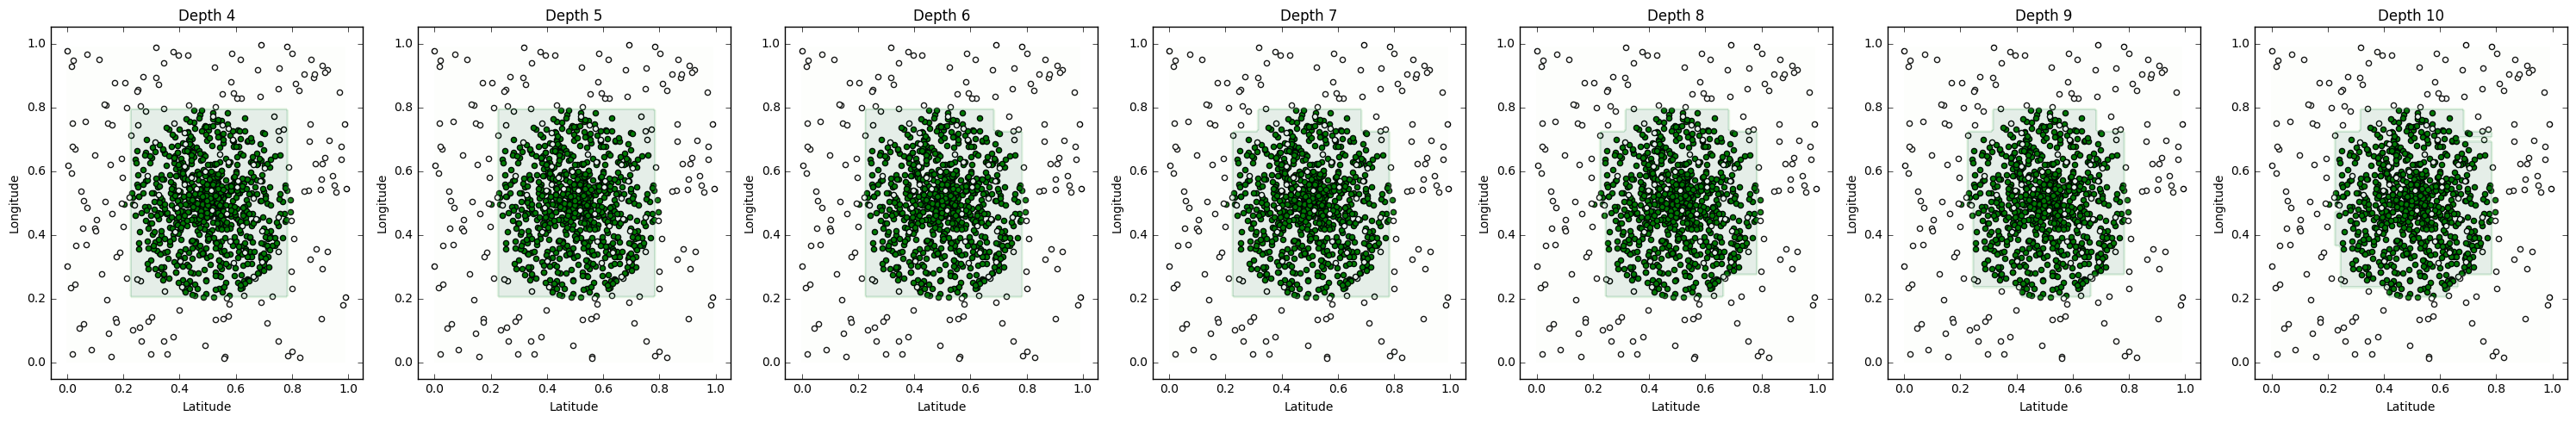

In [15]:
# Plot for dataset_4.txt: depths 1 through 26
fig, ax = plt.subplots(1, len(range(4, 11, 1)), figsize=(30, 5))

#Get the long/lat coords
x = sat_images[3].values[:, :-1]
#Get the class labels
y = sat_images[3].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(4, 11, 1):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Depth {}'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1
    
plt.tight_layout()
plt.show()

Since the vegetation is circular in shape, a decision tree with infinite depth is required to fit this data set.


**Conclusion:** What's our final word then? Which model is better for detecting vegetation in satellite images? In your answer, think about the adaptability and flexibility of each model as well as the computational efficiency.

### Part 1(b). What is the best splitting criterion for decision trees?
Suppose you are given a data set with 100 points in a satellite image, of which 51 are class 1 and 49 are class 0. Consider following two candidate splits for constructing a decision tree: 
1. [Part 1 = (Class 1: 11, Class 0: 37), Part 2 = (Class 1: 40, Class 0: 12)]
2. [Part 1 = (Class 1: 25, Class 0: 48), Part 2 (Class 1: 26, Class 0: 1)]

Which of these is a better split according classification error, Gini coefficient, and Entropy criteria? Do the three criteria agree on the best split, or is one better than the other? Support your answer with a concrete explanation.

In [16]:
# Calculate classification accuracy for a binary split
def err(x1, x2):
    return min((x1,x2))

# Calculate Gini coefficient for a binary split
def Gini(x1, x2):
    return x1*(1-x1) + x2*(1-x2)

# Calculate Cross-entropy for a binary split
def entropy(x1, x2):
    return -x1*np.log(x1) - x2*np.log(x2)

# Split 1:

# Compute split counts
n11 = 48
n12 = 52
n1 = n11 + n12

# Compute split probabilities
x1 = 11./n11
x2 = 37./n11
y1 = 40./n12
y2 = 12./n12

print('Split 1')
print('Error = ' + str((n11*err(x1,x2)+n12*err(y1,y2))/n1))
print('Gini = ' + str((n11*Gini(x1,x2)+n12*Gini(y1,y2))/n1))
print('Entropy = ' + str((n11*entropy(x1,x2)+n12*entropy(y1,y2))/n1))

print('')

# Compute split counts
n21 = 73
n22 = 27
n2 = n21 + n22

# Split 2:
x1 = 25./n21
x2 = 48./n21
y1 = 26./n22
y2 = 1./n22

print('Split 2')
print('Error = ' + str((n21*err(x1,x2)+n22*err(y1,y2))/n2))
print('Gini = ' + str((n21*Gini(x1,x2)+n22*Gini(y1,y2))/n2))
print('Entropy = ' + str((n21*entropy(x1,x2)+n22*entropy(y1,y2))/n2))

Split 1
Error = 0.23
Gini = 0.354198717949
Entropy = 0.539274531592

Split 2
Error = 0.26
Gini = 0.348026382547
Entropy = 0.511910804521


**Observation:** 
While Split 1 has lower error, Split 2 is better, as the partitions are *purer* - the right-hand partition contains an almost perfect classification.

Gini coefficient and Cross-entropy choose Split 2 over Split 1, showing that they promote purer splits. This shows that these are better criteria are than error.

What is the default criterion `sklearn` uses in its decision tree classifier model? Will changing this criterion make any difference in terms of the preformance of our classifier on the satellite images?

## Problem 2: Loan Risk Assessment
In this problem, you are asked by an Unamed National Bank to build a risk assessment model that predicts whether or not it is risky to give a loan to an applicant based on the information provided in their application. Traditionally, loan applications are processed and assessed by hand, but now the bank wants to move to an automated loan processing system. That is, the bank will provide you with loan applications that it has processed in the past for you to build a classifier for risk assessment, going forward, the bank will reject the loan applications from applicants labeled risky and approve the applications that are labeled safe by your model.

The relevant training and test sets are provided in the files: `dataset_5_train.txt` and `dataset_5.test.txt`. The training and testing sets are created from both approved and rejected loan applications that the bank has processed by hand in the past. The first 24 columns contain attributes for each applicant gathered from their application, and the last column contains the credit risk assessment with 1 indicating that the customer is a loan risk, and 0 indicating that the customer is not a loan risk. The names of the attributes are provided in the file `dataset_5_description.txt`.


### Part 2(a): A simple decision tree model
- Fit a simple decision tree of depth 2 to the training set and report its accuracy on the test set. 

- Interpret the way your model performs risk classifcation. Would you recommend this classifier to Unamed National Bank for making decisions on the loan applications of **real people**? If yes, make an argument for the merrits of this classifer. If no, then make necessary changes to the data set and fit a new classifier that you believe is fair to use in practice, then compare the two classifiers.


We have provided you with a function `display_dt` to display the structure of the decision tree in DOT format.

In [48]:
# Print decision tree model 'model', already fitted
def display_dt(model):
    dummy_io = StringIO.StringIO() 
    tree.export_graphviz(model, out_file = dummy_io) 
    print dummy_io.getvalue()

In [273]:
col=['Census Code', 'Amount Credit', 'Gender', 'Education', 'Marital Status','Age',]
for i in range(6,25):
    col.append('X'+str(i))
bank_train = pd.read_csv('datasets/dataset_5_train.txt', delimiter=',', header=None, names =col)
bank_test = pd.read_csv('datasets/dataset_5_test.txt', delimiter=',', header=None, names =col)

#Fixes for Training set
#Education outside of 1 - 4 set to 4
bank_train.Education[bank_train.Education > 4]=4
#-2 out of bounds for X6-X11 set to -1
for i in range(6,12):
    bank_train.ix[:,i][bank_train.ix[:,i] < -1]=-1

#Fixes for Test set
#Education outside of 1 - 4 set to 4
bank_test.Education[bank_test.Education > 4]=4
#-2 out of bounds for X6-X11 set to -1
for i in range(6,12):
    bank_test.ix[:,i][bank_test.ix[:,i] < -1]=-1
    
    
#bank_train.describe().ix[:,12:] 

I found some data that was not correctly entered and was out of the bounds defined in the documentation.

Education that was set > 4 was set to 4.

In any of the X6 - X11 Columns any values that was lower then -1 was set to -1.

In [155]:
bank_train.head()

,Census Code,Amount Credit,Gender,Education,Marital Status,Age,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
0,3288.0,20000.0,2.0,1.0,2.0,39.0,0.0,0.0,0.0,0.0,...,19308.0,19498.0,0.0,1588.0,1770.0,1200.0,390.0,0.0,44334.0,1.0
1,3001.0,50000.0,1.0,2.0,2.0,27.0,2.0,2.0,0.0,0.0,...,7382.0,1975.0,50514.0,4146.0,1200.0,0.0,0.0,49800.0,0.0,1.0
2,3288.0,80000.0,1.0,2.0,2.0,27.0,1.0,2.0,2.0,2.0,...,68531.0,69808.0,70544.0,5000.0,3100.0,2000.0,3000.0,2000.0,4000.0,1.0
3,3652.0,70000.0,2.0,2.0,2.0,22.0,0.0,0.0,0.0,0.0,...,69316.0,29083.0,28140.0,3200.0,3600.0,3075.0,1204.0,1200.0,1046.0,0.0
4,3817.0,200000.0,1.0,1.0,2.0,24.0,-1.0,-1.0,-1.0,-1.0,...,18154.0,13677.0,2018.0,200.0,198.0,18156.0,0.0,1150.0,0.0,0.0


In [156]:
bank_test.head()

,Census Code,Amount Credit,Gender,Education,Marital Status,Age,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
0,3652.0,210000.0,2.0,3.0,1.0,28.0,0.0,0.0,0.0,0.0,...,41084.0,42416.0,43707.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,0.0
1,3662.0,110000.0,2.0,3.0,1.0,55.0,-1.0,2.0,0.0,0.0,...,5819.0,4807.0,5579.0,0.0,1087.0,1532.0,0.0,1000.0,0.0,1.0
2,3530.0,70000.0,1.0,3.0,1.0,45.0,2.0,2.0,2.0,2.0,...,67338.0,70769.0,68957.0,3100.0,3008.0,0.0,5100.0,2600.0,0.0,1.0
3,3827.0,130000.0,1.0,1.0,1.0,40.0,2.0,2.0,0.0,0.0,...,86407.0,88959.0,97487.0,0.0,5000.0,5000.0,4000.0,10000.0,3724.0,1.0
4,3288.0,710000.0,2.0,2.0,1.0,40.0,-1.0,-1.0,-1.0,-1.0,...,1004.0,854.0,8626.0,0.0,0.0,1004.0,0.0,8000.0,5000.0,1.0


In [157]:
bank_train.describe()

,Census Code,Amount Credit,Gender,Education,Marital Status,Age,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
count,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.0000,250.000000
mean,3403.628000,159080.000000,1.536000,1.90400,1.620000,34.712000,0.256000,0.280000,0.132000,0.044000,...,45817.300000,41864.856000,39893.556000,5718.272000,3611.308000,5387.684000,3095.892000,4107.592000,4841.6440,0.512000
std,247.269705,125123.046266,0.499703,0.67573,0.526029,8.674216,1.048265,1.239251,1.116945,1.046156,...,72096.790882,68071.150153,58840.614519,14731.050866,4867.444286,17753.643336,5501.622103,9540.206922,17830.1525,0.500859
min,3001.000000,10000.000000,1.000000,1.00000,1.000000,22.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1247.000000,-28335.000000,-8026.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
25%,3288.000000,60000.000000,1.000000,1.00000,1.000000,28.000000,0.000000,-1.000000,-1.000000,-1.000000,...,2290.500000,1638.750000,1464.250000,325.250000,793.000000,0.000000,0.500000,53.500000,217.7500,0.000000
50%,3298.000000,130000.000000,2.000000,2.00000,2.000000,33.000000,0.000000,0.000000,0.000000,0.000000,...,19667.500000,18193.000000,18012.000000,2053.500000,2009.500000,1700.000000,1500.000000,1602.000000,1364.5000,1.000000
75%,3585.000000,220000.000000,2.000000,2.00000,2.000000,40.750000,1.000000,0.000000,0.000000,0.000000,...,51953.500000,52292.250000,51561.250000,4587.250000,4961.500000,4022.750000,3579.500000,4205.750000,3452.2500,1.000000
max,3827.000000,550000.000000,2.000000,4.00000,3.000000,69.000000,3.000000,6.000000,5.000000,4.000000,...,548020.000000,530672.000000,373095.000000,150000.000000,36575.000000,188841.000000,58276.000000,107591.000000,194102.0000,1.000000


In [158]:
bank_test.describe()

,Census Code,Amount Credit,Gender,Education,Marital Status,Age,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
count,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000,...,9750.000000,9750.000000,9750.000000,9750.000000,9.750000e+03,9750.000000,9750.000000,9750.000000,9750.000000,9750.000000
mean,3399.346051,154596.685128,1.587179,1.856615,1.542051,35.551385,0.306872,0.199385,0.159795,0.094462,...,43212.526359,40247.166769,38881.885128,5024.239385,5.309438e+03,4639.720205,4349.078974,4306.895282,4496.862154,0.501641
std,253.006995,127038.656035,0.492366,0.736039,0.521588,9.427644,1.166243,1.202811,1.180979,1.154138,...,64713.789517,60931.733439,59540.505003,16523.722347,2.615207e+04,17047.618092,14856.703728,14493.402056,15685.656606,0.500023
min,3001.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-65167.000000,-61372.000000,-94625.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3288.000000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2371.250000,1790.500000,1316.250000,390.000000,3.900000e+02,179.250000,12.000000,15.250000,0.000000,0.000000
50%,3298.000000,120000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19261.000000,18461.000000,17665.000000,2000.000000,2.000000e+03,1515.000000,1303.500000,1375.500000,1250.500000,1.000000
75%,3585.000000,220000.000000,2.000000,2.000000,2.000000,42.000000,1.000000,0.000000,0.000000,0.000000,...,52054.250000,49068.000000,48208.500000,4710.750000,4.503750e+03,4000.000000,3699.250000,3747.250000,3500.000000,1.000000
max,3827.000000,760000.000000,2.000000,4.000000,3.000000,75.000000,8.000000,8.000000,8.000000,8.000000,...,616836.000000,547880.000000,527711.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,443001.000000,1.000000


In [364]:
print 'Count of Low Risk Clients Approved for a Loan'
print bank_test[bank_test.X24==1].count()[24]
print 'Count of High Risk Clients'
print bank_test[bank_test.X24==0].count()[24]

Count of Low Risk Clients Approved for a Loan
4891
Count of High Risk Clients
4859


Dataset is well balanced and is not biases into any direction

In [365]:
#Tree Max Depth = 2

clfTree1 = tree.DecisionTreeClassifier(max_depth=2, criterion='gini')

Xtrain=bank_train.ix[:,0:23]
ytrain=bank_train.ix[:,24]

Xtest=bank_test.ix[:,0:23]
ytest=bank_test.ix[:,24]

# FIT THE TREE 
clf=clfTree1.fit(Xtrain, ytrain)

training_accuracy = clf.score(Xtrain, ytrain)



test_accuracy = clf.score(Xtest, ytest)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clf.predict(Xtest))
print "########################################################"

############# based on standard predict ################
Accuracy on training data: 0.90
Accuracy on test data:     0.88
[[4407  452]
 [ 712 4179]]
########################################################


In [214]:
display_dt(clf)

digraph Tree {
node [shape=box] ;
0 [label="X[0] <= 3293.0\ngini = 0.4997\nsamples = 250\nvalue = [122, 128]"] ;
1 [label="X[2] <= 1.5\ngini = 0.1338\nsamples = 111\nvalue = [8, 103]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.2563\nsamples = 53\nvalue = [8, 45]"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 58\nvalue = [0, 58]"] ;
1 -> 3 ;
4 [label="X[0] <= 3822.0\ngini = 0.295\nsamples = 139\nvalue = [114, 25]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.2159\nsamples = 130\nvalue = [114, 16]"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 9\nvalue = [0, 9]"] ;
4 -> 6 ;
}


This Decision Tree model was fitted and tested. It performed well misclassifying 12% of the data. I would not recommend this to the Unnamed bank as it had only used 1 feature column to decide on the data. The tree is only 2 nodes deep and does not make decisions based on the various other data/information we have.

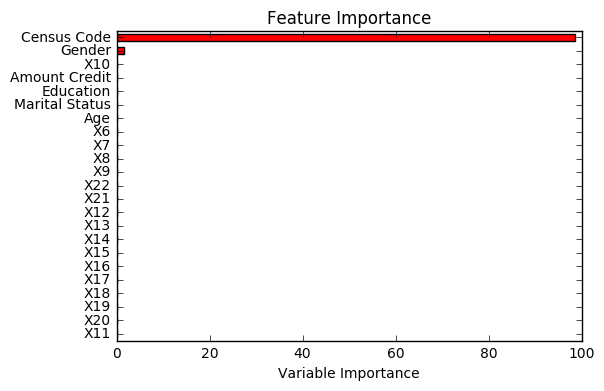

In [366]:
Importance = pd.DataFrame({'Importance':clf.feature_importances_*100}, index=col)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.title('Feature Importance')

In an attempt to improve the current model, I have checked the models predictive power by changing the max_depth in the range of 1-12 to see if we could find an improvement.

In [367]:
test_score = []
train_score = []
for i in range(1,12):

    clfTree1 = tree.DecisionTreeClassifier(max_depth=i, criterion='gini')
   
    Xtrain=bank_train.ix[:,0:23]
    ytrain=bank_train.ix[:,24]

    Xtest=bank_test.ix[:,0:23]
    ytest=bank_test.ix[:,24]

    # TRAINING AND TESTING
    #Xtrain, Xtest, ytrain, ytest = X, X, y, y

    # FIT THE TREE 
    clf=clfTree1.fit(Xtrain, ytrain)

    training_accuracy = clf.score(Xtrain, ytrain)
    train_score.append(clf.score(Xtrain, ytrain)) 
    

    test_accuracy = clf.score(Xtest, ytest)
    test_score.append(clf.score(Xtest, ytest))

print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clf.predict(Xtest))
print "########################################################"

############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.83
[[4156  703]
 [ 972 3919]]
########################################################


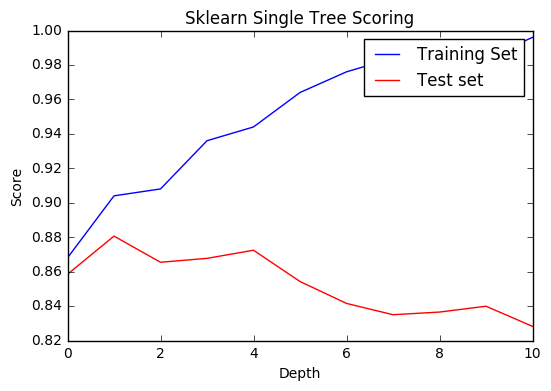

In [368]:
plt.plot(train_score,c='b')
plt.plot(test_score,c='r')
plt.title('Sklearn Single Tree Scoring')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.legend(['Training Set','Test set'])

I chose to use tree depth 4 as the model seems to have a good mix between bias and predictive power. Checking the features it was using would be important

In [253]:

clfTree1 = tree.DecisionTreeClassifier(max_depth=4, criterion='gini')

Xtrain=bank_train.ix[:,0:23]
ytrain=bank_train.ix[:,24]

Xtest=bank_test.ix[:,0:23]
ytest=bank_test.ix[:,24]

# TRAINING AND TESTING
#Xtrain, Xtest, ytrain, ytest = X, X, y, y

# FIT THE TREE 
clf=clfTree1.fit(Xtrain, ytrain)

training_accuracy = clf.score(Xtrain, ytrain)



test_accuracy = clf.score(Xtest, ytest)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clf.predict(Xtest))
print "########################################################"

############# based on standard predict ################
Accuracy on training data: 0.94
Accuracy on test data:     0.87
[[4295  564]
 [ 726 4165]]
########################################################


In [218]:
display_dt(clf)

digraph Tree {
node [shape=box] ;
0 [label="X[0] <= 3293.0\ngini = 0.4997\nsamples = 250\nvalue = [122, 128]"] ;
1 [label="X[2] <= 1.5\ngini = 0.1338\nsamples = 111\nvalue = [8, 103]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[19] <= 6827.5\ngini = 0.2563\nsamples = 53\nvalue = [8, 45]"] ;
1 -> 2 ;
3 [label="X[6] <= 0.5\ngini = 0.1866\nsamples = 48\nvalue = [5, 43]"] ;
2 -> 3 ;
4 [label="gini = 0.3107\nsamples = 26\nvalue = [5, 21]"] ;
3 -> 4 ;
5 [label="gini = 0.0\nsamples = 22\nvalue = [0, 22]"] ;
3 -> 5 ;
6 [label="X[19] <= 10287.5\ngini = 0.48\nsamples = 5\nvalue = [3, 2]"] ;
2 -> 6 ;
7 [label="gini = 0.0\nsamples = 3\nvalue = [3, 0]"] ;
6 -> 7 ;
8 [label="gini = 0.0\nsamples = 2\nvalue = [0, 2]"] ;
6 -> 8 ;
9 [label="gini = 0.0\nsamples = 58\nvalue = [0, 58]"] ;
1 -> 9 ;
10 [label="X[0] <= 3822.0\ngini = 0.295\nsamples = 139\nvalue = [114, 25]"] ;
0 -> 10 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
11 [label="X[7] <= 1.0\ngini = 0.215

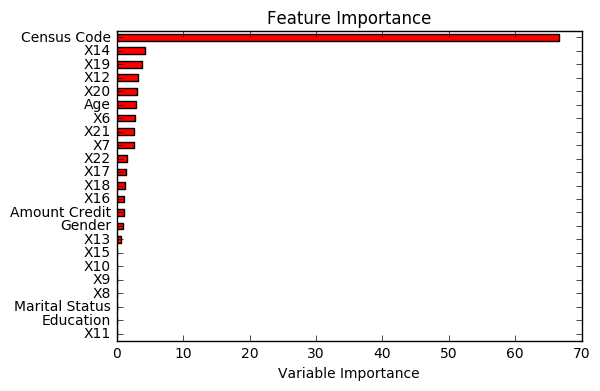

In [361]:
Importance = pd.DataFrame({'Importance':clf.feature_importances_*100}, index=col)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.title('Feature Importance')

The score is slightly lower than the initial model, but we have identified alot more columns in the dataset, that help influence the decision trees power. I would still not recommend this model to unnamed bank over the initial one, but it does display better attributes while having a similar score to the past model.

### Part 2(b): An ensemble of decision trees

- One way to improve the prediciton accuracy for this task is to use an ensemble of decision trees fitted on random samples, as follows: given a training set of size $n$, sample new training sets uniformly with replacement, and fit a decision tree model on each random sample.

  Now, how would you combine the ensemble into a single classifier? There are at lease two ways:

   - *Random classifier*: predict using a randomly chosen decision tree from the ensemble
   - *Majority classifier*: predict using the majority vote from decision trees in the ensemble
   
   

- We can also fit a *Random Forest* model for our data (`sklearn.ensemble.RandomForestClassifier`).

Is there a significant difference in the prediction accuracies of the above three approaches on the loan data set? If so, explain why.


**Note:**  The Random Forest approach can easily overfit the training set. What are the important parameters in `sklearn`'s Random Forest fitting function that influence the model fit? For the risk assessment task, you **need** to fit your random forest model by using a suitable model selection procedure to tune these parameters.





In [395]:
#Random Ensemble Trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
X=bank_train.ix[:,0:23]
y=bank_train.ix[:,24]

Xtest=bank_test.ix[:,0:23]
ytest=bank_test.ix[:,24]
clf = ExtraTreesClassifier(n_estimators=30, max_depth=5,
    min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y)
print scores

clf=clf.fit(Xtrain, ytrain)

print clf.n_estimators

training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)
print "############# Random Ensemble Tree ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clf.predict(Xtest))
print "########################################################"

[ 0.85714286  0.78571429  0.80487805]
30
############# Random Ensemble Tree ################
Accuracy on training data: 0.87
Accuracy on test data:     0.80
[[3856 1003]
 [ 945 3946]]
########################################################


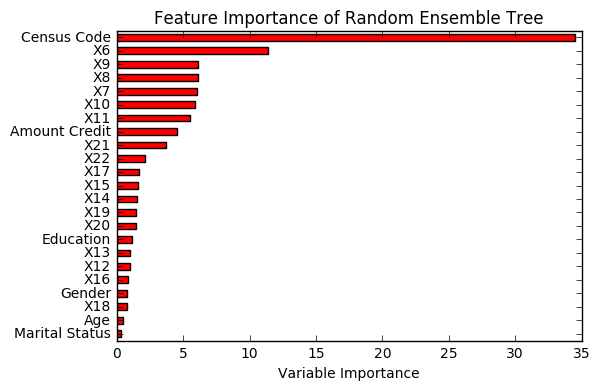

In [397]:
Importance = pd.DataFrame({'Importance':clf.feature_importances_*100}, index=col)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.title('Feature Importance of Random Ensemble Tree')

In [410]:
#Bagging Trees / Majority Vote
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=4, criterion='gini'),
    max_samples=0.7, max_features=0.7, oob_score=True)



X=bank_train.ix[:,0:23]
y=bank_train.ix[:,24]

Xtest=bank_test.ix[:,0:23]
ytest=bank_test.ix[:,24]

scores = cross_val_score(clf, X, y)
print scores

clf=bagging.fit(Xtrain, ytrain)

print clf.n_estimators

training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)
print "############# Bagging Tree Predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clf.predict(Xtest))
print "########################################################"

[ 0.89285714  0.8452381   0.87804878]
10
############# Bagging Tree Predict ################
Accuracy on training data: 0.93
Accuracy on test data:     0.87
[[4192  667]
 [ 560 4331]]
########################################################


In [432]:
bagging = clf.get_params()
bagging.get('base_estimator').fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

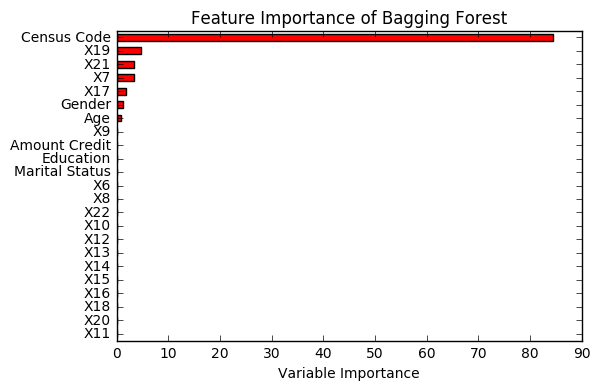

In [434]:
Importance = pd.DataFrame({'Importance':bagging.get('base_estimator').feature_importances_*100}, index=col)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.title('Feature Importance of Bagging Forest')

The parameters used to tune the Random forest is:

parameters = {"n_estimators": range(1, 20), "max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [342]:
# Create test/train mask
itrain, itest = train_test_split(xrange(bank_train.shape[0]), train_size=0.3)
mask=np.ones(bank_train.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [387]:
from sklearn.ensemble import RandomForestClassifier
import StringIO


clfForest = RandomForestClassifier( n_estimators=23, oob_score=True, max_features='auto')

Xtrain=bank_train.ix[:,0:23]
ytrain=bank_train.ix[:,24]

Xtest=bank_test.ix[:,0:23]
ytest=bank_test.ix[:,24]
# FIT THE TREE 

clf=clfForest.fit(Xtrain, ytrain)

print 'No of estimators'
print clfForest.n_estimators

training_accuracy = clfForest.score(Xtrain, ytrain)
test_accuracy = clfForest.score(Xtest, ytest)
clfForest1=clfForest
print "############# Random Forest ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clf.predict(Xtest))
print "########################################################"
col = col[0:23]
parameters = {"n_estimators": range(1, 20), "max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                      bank_train, col, 'X24', 1, mask=mask, 
                                                      n_jobs = 4, score_func='f1')

print 'No of estimators in RF with CV and GridSearch'
print clfForest.n_estimators



No of estimators
23
############# Random Forest ################
Accuracy on training data: 1.00
Accuracy on test data:     0.84
[[4088  771]
 [ 745 4146]]
########################################################
using mask


C:\Users\mezot\Anaconda3\envs\Python27\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


############# based on standard predict ################
Accuracy on training data: 0.88
Accuracy on test data:     0.81
[[63 24]
 [ 9 79]]
########################################################
No of estimators in RF with CV
17


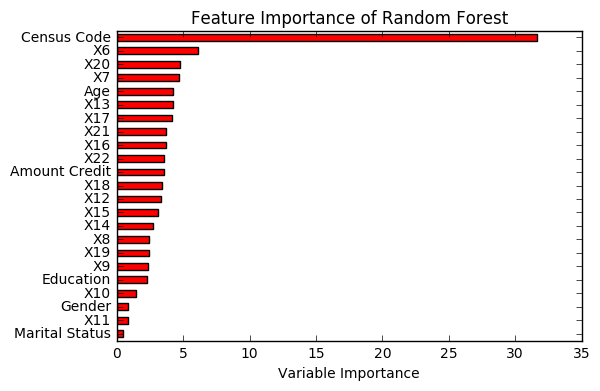

In [388]:
Importance = pd.DataFrame({'Importance':clfForest1.feature_importances_*100}, index=col)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.title('Feature Importance of Random Forest')

In [389]:
#Testing accuracy on entire dataset instead of subset
Xtrain=bank_train.ix[:,0:23]
ytrain=bank_train.ix[:,24]

Xtest=bank_test.ix[:,0:23]
ytest=bank_test.ix[:,24]

training_accuracy = clfForest.score(Xtrain, ytrain)
test_accuracy = clfForest.score(Xtest, ytest)

print "############# Random Forest With CV and GridSearch ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clfForest.predict(Xtest))
print "########################################################"

############# Random Forest Subset ################
Accuracy on training data: 0.83
Accuracy on test data:     0.77
[[3267 1592]
 [ 661 4230]]
########################################################


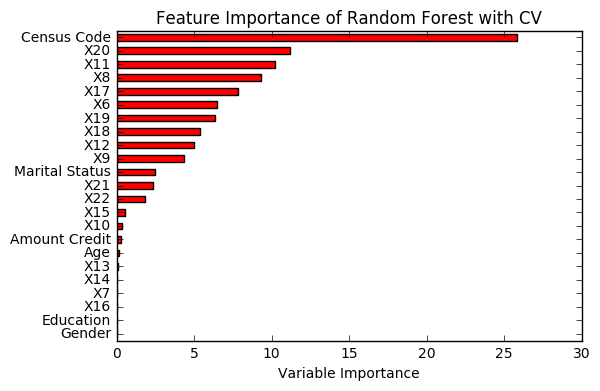

In [390]:
Importance = pd.DataFrame({'Importance':clfForest.feature_importances_*100}, index=col)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.title('Feature Importance of Random Forest with CV and Gridsearch')

In [268]:
# A generic function to do CV

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)

    best = gs.best_estimator_
    return best

In [386]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest


Interestingly Random Tree Classifier and Bagging Forest Classifier found some important features besides the initial Census Code column, that allowed the data to speak. The features selected were not observed in the models from Question 2a. The Random Forest improved from there by finding 23 important predictors, and after Gridsearch and Cross-Validation was performed, the features importances greatly increased, while only selecting 17 important features. The scores however did not improve much from the initial model.

## Challenge Problem: Boosting for Classification

We've seen in class that boosting is a useful ensemble method to combine a collection of simple regression trees into a powerful regression model. Chapter 10.1 of the text book ([*J.H. Friedman, R. Tibshirani, and T. Hastie, "The Elements of Statistical Learning"*](http://statweb.stanford.edu/~tibs/ElemStatLearn/)) describes the boosting technique for classification trees. Implement the method from scratch.
    
Write a function `fit_and_score_boosted_trees` satisfying:
- Input:
    - `x_train`:  Array of predictors in training set
    - `y_train`:  Array of binary responses in training set
    - `x_test`:  Array of predictors in training set
    - `y_test`:  Array of binary responses in training set
    - `M`:  Number of iterations / Number of decision trees in the ensemble
    - `depth`:  Depth of each decision tree
- Fits an ensemble of `T` decision trees to the training set
- Output:
    - `test_accuracy`:  classification accuracy of the ensemble on the test set

Your function will also have to **standardise** the predictors in the training and test sets before applying boosting.
   
**Hints:** 
- `sklearn`'s decision tree learning routine has an option to specific weights on the training points
- `sklearn`'s classifiers make predictions in {0,1} while the book assumes predictions in {-1, 1}

Your implementation will be evaluated based on three test cases: 

`challenge_testcase_1_train.txt`, `challenge_testcase_1_test.txt`

`challenge_testcase_2_train.txt`, `challenge_testcase_2_test.txt`

`challenge_testcase_3_train.txt`, `challenge_testcase_3_test.txt`

These cases represent extreme examples of data (each dataset contains a particular type of pathology) that might break an implementaiton that is not carefully thought through. 

**Run the code given below to test your implementation. Call `test_implementation` and pass it your function `fit_and_score_boosted_trees`.**

In [1]:
#--------  test_implementation
# A function that tests your fit_and_score_boosted_trees function using three test sets.
# Input: 
#      fit_and_score_boosted_trees (your implementation of the boosting function)
# Returns: 
#      None

def test_implementation(fit_and_score_boosted_trees):
    
    # Iterate over test cases
    for i in range(1,4):
        # Load train & test data
        data_train = np.loadtxt('testcases/challenge_testcase_' + str(i) + '_train.txt', delimiter=',')
        data_test = np.loadtxt('testcases/challenge_testcase_' + str(i) + '_test.txt', delimiter=',')

        # Split label and instances
        y_train = data_train[:,-1]
        x_train = data_train[:,0:-1]

        y_test = data_test[:,-1]
        x_test = data_test[:,0:-1]

        # Run boosting function
        print 'Test case', i, ':', fit_and_score_boosted_trees(x_train, y_train, x_test, y_test, 10, 2)    